In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import numpy as np
import mne
from mne import Epochs
from mne.datasets.fieldtrip_cmc import data_path
from mne.utils import _time_mask
from mne.channels import read_layout
from mne.decoding import TransformerMixin, BaseEstimator
from ssd import  SSD

import locale
locale.setlocale(locale.LC_ALL, "en_US.UTF-8") #needed for local machine in spanish

'en_US.UTF-8'

In [2]:
def freq_mask(freqs, fmin, fmax):
    """convenience function to select frequencies"""
    return _time_mask(freqs, fmin, fmax)


In [3]:
# Define parameters
fname = data_path() + '/SubjectCMC.ds'
raw = mne.io.read_raw_ctf(fname)
raw.crop(50., 250.).load_data()  # crop for memory purposes

freqs_sig = 9, 12
freqs_noise = 8, 13


picks=mne.pick_types(raw.info, meg=True, eeg=False, ref_meg=False)

ds directory : /home/victoria/mne_data/MNE-fieldtrip_cmc-data/SubjectCMC.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.33   78.32    0.00 mm <->    0.33   78.32    0.00 mm (orig :  -71.62   40.46 -256.48 mm) diff =    0.000 mm
      -0.33  -78.32   -0.00 mm <->   -0.33  -78.32   -0.00 mm (orig :   39.27  -70.16 -258.60 mm) diff =    0.000 mm
     114.65    0.00   -0.00 mm <->  114.65    0.00    0.00 mm (orig :   64.35   66.64 -262.01 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 4 EEG channels from channel info
    4 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /home/victoria/mne_data/MNE-fieldtrip_cmc-data/SubjectCMC.ds/SubjectCMC.meg4: 
    System clock channel is available, checking which samples are vali

In [4]:
#SSD
ssd = SSD(filt_params_signal=dict(l_freq=freqs_sig[0], h_freq=freqs_sig[1],
                                  l_trans_bandwidth=1, h_trans_bandwidth=1,
                                  fir_design='firwin'),
          filt_params_noise=dict(l_freq=freqs_noise[0], h_freq=freqs_noise[1],
                                  l_trans_bandwidth=1, h_trans_bandwidth=1,
                                  fir_design='firwin'), 
          sampling_freq=raw.info['sfreq'], picks=picks)

In [5]:
#fit
ssd.fit(raw.copy().crop(0, 120))

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 3961 samples (3.301 sec)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

/home/victoria/anaconda3/envs/icn/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SSD(cov_method_params=None, estimator='oas',
    filt_params_noise={'fir_design': 'firwin', 'h_freq': 13,
                       'h_trans_bandwidth': 1, 'l_freq': 8,
                       'l_trans_bandwidth': 1},
    filt_params_signal={'fir_design': 'firwin', 'h_freq': 12,
                        'h_trans_bandwidth': 1, 'l_freq': 9,
                        'l_trans_bandwidth': 1},
    n_components=None, n_fft=600, picks=None, rank=None, sampling_freq=1200.0,
    sort_by_spectral_ratio=True)

In [6]:
#transform
ssd_sources = ssd.transform(raw)

Effective window size : 0.500 (s)


In [7]:
#get info 
spec_ratio = ssd.spec_ratio
sorter = ssd.sorter_spec

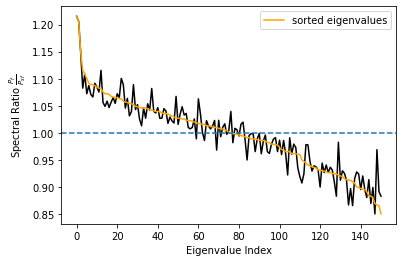

In [8]:
# plot spectral ratio (see Eq. 24 in Nikulin 2011)
plt.figure()
plt.plot(spec_ratio, color='black')
plt.plot(spec_ratio[sorter], color='orange', label='sorted eigenvalues')
plt.xlabel("Eigenvalue Index")
plt.ylabel(r"Spectral Ratio $\frac{P_f}{P_{sf}}$")
plt.legend()
plt.axhline(1, linestyle='--')

### We see that the first 4 sorted eigenvalues correspon to the higher Spectral ratio value. 

In [9]:
print(sorter[:4])

[ 0  1  2 12]


Effective window size : 3.413 (s)


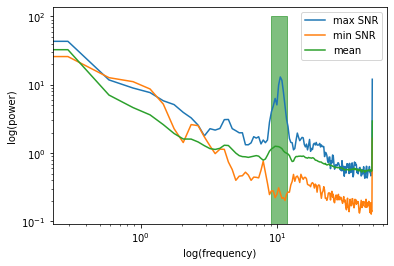

In [12]:
psd, freqs = mne.time_frequency.psd_array_welch(
    ssd_sources, sfreq=raw.info['sfreq'], n_fft=4096)

below50 = freq_mask(freqs, 0, 50)
bandfilt = freq_mask(freqs, freqs_sig[0],freqs_sig[1])

plt.figure()
plt.loglog(freqs[below50], psd[0, below50], label='max SNR')
plt.loglog(freqs[below50], psd[-1, below50], label='min SNR')
plt.loglog(freqs[below50], psd[:, below50].mean(axis=0), label='mean')
plt.fill_between(freqs[bandfilt], 0, 100,\
                color='green', alpha=0.5)
plt.xlabel("log(frequency)")
plt.ylabel("log(power)")
plt.legend()

#### The topographies suggest that we picked up a parietal alpha generator.


## Let's check the implementation for epoched data. 
### Although we suggest to use this method before epoching, there might be some situations in which data can only be treated by chunks

In [13]:
raw.pick_types(meg=True, ref_meg=False, eeg=False, eog=False)
# Build epochs as sliding windows over the continuous raw file
events = mne.make_fixed_length_events(raw, id=1, duration=.250)

# Epoch length is 1.5 second
meg_epochs = Epochs(raw, events, tmin=0., tmax=1, baseline=None,
                    detrend=1, decim=1)

Removing 5 compensators from info because not all compensation channels were picked.
800 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [14]:
X=meg_epochs.get_data()

Loading data for 800 events and 1201 original time points ...
3 bad epochs dropped


In [15]:
#fit
ssd.fit(X)

Setting up band-pass filter from 9 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 8.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 3961 samples (3.301 sec)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- F

Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.4e-13 (2.2e-16 eps * 151 dim * 28  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 151 dim * 39  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-12 (2.2e-16 eps * 151 dim * 48  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-12 (2.2e-16 eps * 151 dim * 46  m

    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 33  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 32  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estim

Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-12 (2.2e-16 eps * 151 dim * 40  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 32  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.9e-13 (2.2e-16 eps * 151 dim * 27  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-13 (2.2e-16 eps * 151 dim * 30  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.7e-13 (2.2e-16 eps * 151 dim * 29  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Don

Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 33  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 34  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 151 dim * 40  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-12 (2.2e-16 eps * 151 dim * 40  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-13 (2.2e-16 eps * 151 dim * 13  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-13 (2.2e-16 eps * 151 dim * 19  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

    Using tolerance 7.9e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-13 (2.2e-16 eps * 151 dim * 22  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from

Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5e-13 (2.2e-16 eps * 151 dim * 15  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.1e-13 (2.2e-16 eps * 151 dim * 12  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-

    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-13 (2.2e-16 eps * 151 dim * 27  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-13 (2.2e-16 eps * 151 dim * 19  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estim

Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-12 (2.2e-16 eps * 151 dim * 35  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 32  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated r

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.7e-13 (2.2e-16 eps * 151 dim * 26  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e-13 (2.2e-16 eps * 151 dim * 22  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.7e-13 (2.2e-16 eps * 151 dim * 26  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Computing rank from data with rank=None
    Using tolerance 6.8e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-13 (2.2e-16 eps * 151 dim * 23  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 32  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 34  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 33  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 32  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 34  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 32  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e-13 (2.2e-16 eps * 151 dim * 23  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 34  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.7e-13 (2.2e-16 eps * 151 dim * 29  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-12 (2.2e-16 eps * 151 dim * 66  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-12 (2.2e-16 eps * 151 dim * 61  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-12 (2.2e-16 eps * 151 dim * 50  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-12 (2.2e-16 eps * 151 dim * 41  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-13 (2.2e-16 eps * 151 dim * 23  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-13 (2.2e-16 eps * 151 dim * 18  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 33  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e-13 (2.2e-16 eps * 151 dim * 28  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.1e-13 (2.2e-16 eps * 151 dim * 27  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 34  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-12 (2.2e-16 eps * 151 dim * 37  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 151 dim * 40  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-12 (2.2e-16 eps * 151 dim * 47  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 32  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 33  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.

Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 151 dim * 39  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-12 (2.2e-16 eps * 151 dim * 43  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-12 (2.2e-16 eps * 151 dim * 41  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 151 dim * 39  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-12 (2.2e-16 eps * 151 dim * 44  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 151 dim * 38  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Don

Done.
Computing rank from data with rank=None
    Using tolerance 9.4e-13 (2.2e-16 eps * 151 dim * 28  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 32  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 33  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1e-12 (2.2e-16 eps * 151 dim * 31  max singular value)
    Estimated r

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-12 (2.2e-16 eps * 151 dim * 35  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-12 (2.2e-16 eps * 151 dim * 35  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-12 (2.2e-16 eps * 151 dim * 35  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 34  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-12 (2.2e-16 eps * 151 dim * 32  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e-13 (2.2e-16 eps * 151 dim * 28  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-13 (2.2e-16 eps * 151 dim * 22  max singular value)
    Estimated rank 

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.8e-13 (2.2e-16 eps * 151 dim * 26  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-13 (2.2e-16 eps * 151 dim * 28  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Don

Computing rank from data with rank=None
    Using tolerance 6.9e-13 (2.2e-16 eps * 151 dim * 21  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-13 (2.2e-16 eps * 151 dim * 21  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-13 (2.2e-16 eps * 151 dim * 11  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-13 (2.2e-16 eps * 151 dim * 19  max singular value)
    Estimated rank 

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.9e-13 (2.2e-16 eps * 151 dim * 15  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-13 (2.2e-16 eps * 151 dim * 13  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-13 (2.2e-16 eps * 151 dim * 11  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-13 (2.2e-16 eps * 151 dim * 15  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-13 (2.2e-16 eps * 151 dim * 11  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-13 (2.2e-16 eps * 151 dim * 13  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-13 (2.2e-16 eps * 151 dim * 18  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-13 (2.2e-16 eps * 151 dim * 18  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-13 (2.2e-16 eps * 151 dim * 29  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-13 (2.2e-16 eps * 151 dim * 21  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-13 (2.2e-16 eps * 151 dim * 19  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7e-13 (2.2e-16 eps * 151 dim * 21  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-13 (2.2e-16 eps * 151 dim * 19  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Don

Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-13 (2.2e-16 eps * 151 dim * 13  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e-13 (2.2e-16 eps * 151 dim * 22  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-13 (2.2e-16 eps * 151 dim * 23  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.5e-13 (2.2e-16 eps * 151 dim * 16  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-13 (2.2e-16 eps * 151 dim * 11  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-13 (2.2e-16 eps * 151 dim * 8.1  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-13 (2.2e-16 eps * 151 dim * 11  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-13 (2.2e-16 eps * 151 dim * 11  max singular value)
    Estimate

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-13 (2.2e-16 eps * 151 dim * 13  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.2e-13 (2.2e-16 eps * 151 dim * 12  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 3.8e-13 (2.2e-16 eps * 151 dim * 11  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 5.1e-13 (2.2e-16 eps * 151 dim * 15  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7e-13 (2.2e-16 eps * 151 dim * 21  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4e-13 (2.2e-16 eps * 151 dim * 12  max singular value)
    Estimated ran

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.4e-13 (2.2e-16 eps * 151 dim * 13  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.4e-13 (2.2e-16 eps * 151 dim * 16  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-13 (2.2e-16 eps * 151 dim * 14  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-13 (2.2e-16 eps * 151 dim * 14  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-13 (2.2e-16 eps * 151 dim * 22  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-13 (2.2e-16 eps * 151 dim * 21  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-13 (2.2e-16 eps * 151 dim * 22  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.8e-13 (2.2e-16 eps * 151 dim * 26  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-13 (2.2e-16 eps * 151 dim * 18  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-13 (2.2e-16 eps * 151 dim * 22  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-13 (2.2e-16 eps * 151 dim * 19  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.7e-13 (2.2e-16 eps * 151 dim * 26  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-13 (2.2e-16 eps * 151 dim * 26  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Don

Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-12 (2.2e-16 eps * 151 dim * 34  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9e-13 (2.2e-16 eps * 151 dim * 27  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9.2e-13 (2.2e-16 eps * 151 dim * 28  max singular value)
    Estimated r

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.5e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.4e-13 (2.2e-16 eps * 151 dim * 16  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-13 (2.2e-16 eps * 151 dim * 21  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Computing rank from data with rank=None
    Using tolerance 8.5e-13 (2.2e-16 eps * 151 dim * 25  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-13 (2.2e-16 eps * 151 dim * 18  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7e-13 (2.2e-16 eps * 151 dim * 21  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated rank (m

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.5e-13 (2.2e-16 eps * 151 dim * 16  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9e-13 (2.2e-16 eps * 151 dim * 27  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Don

Computing rank from data with rank=None
    Using tolerance 7.8e-13 (2.2e-16 eps * 151 dim * 23  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.3e-13 (2.2e-16 eps * 151 dim * 22  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6e-13 (2.2e-16 eps * 151 dim * 18  max singular value)
    Estimated rank (m

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-13 (2.2e-16 eps * 151 dim * 18  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.1e-13 (2.2e-16 eps * 151 dim * 15  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

    Using tolerance 8.2e-13 (2.2e-16 eps * 151 dim * 25  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.5e-13 (2.2e-16 eps * 151 dim * 22  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 9e-13 (2.2e-16 eps * 151 dim * 27  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 1

Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-13 (2.2e-16 eps * 151 dim * 26  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5e-13 (2.2e-16 eps * 151 dim * 15  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4e-13

    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-13 (2.2e-16 eps * 151 dim * 23  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-12 (2.2e-16 eps * 151 dim * 37  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-12 (2.2e-16 eps * 151 dim * 39  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Est

Done.
Computing rank from data with rank=None
    Using tolerance 7.8e-13 (2.2e-16 eps * 151 dim * 23  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.8e-13 (2.2e-16 eps * 151 dim * 26  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.3e-13 (2.2e-16 eps * 151 dim * 25  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5e-13 (2.2e-16 eps * 151 dim * 15  max singular value)
    Estimated r

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-13 (2.2e-16 eps * 151 dim * 20  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-13 (2.2e-16 eps * 151 dim * 17  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-13 (2.2e-16 eps * 151 dim * 15  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
D

Done.
Computing rank from data with rank=None
    Using tolerance 4.5e-13 (2.2e-16 eps * 151 dim * 14  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-13 (2.2e-16 eps * 151 dim * 14  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.5e-13 (2.2e-16 eps * 151 dim * 16  max singular value)
    Estimated rank (mag): 151
    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-13 (2.2e-16 eps * 151 dim * 24  max singular value)
    Estimated

    MAG: rank 151 computed from 151 data channels with 0 projectors
Reducing data rank from 151 -> 151
Estimating covariance using OAS
Done.


/home/victoria/anaconda3/envs/icn/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SSD(cov_method_params=None, estimator='oas',
    filt_params_noise={'fir_design': 'firwin', 'h_freq': 13,
                       'h_trans_bandwidth': 1, 'l_freq': 8,
                       'l_trans_bandwidth': 1},
    filt_params_signal={'fir_design': 'firwin', 'h_freq': 12,
                        'h_trans_bandwidth': 1, 'l_freq': 9,
                        'l_trans_bandwidth': 1},
    n_components=None, n_fft=600, picks=None, rank=None, sampling_freq=1200.0,
    sort_by_spectral_ratio=True)

In [16]:
#transform
ssd_sources_epochs = ssd.transform(X)

Effective window size : 0.500 (s)


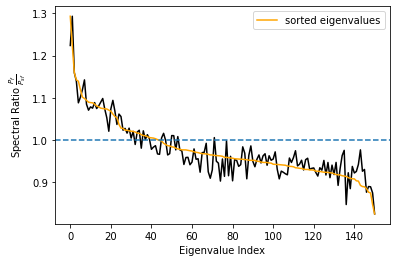

In [17]:
#as before, let's check the spatial component and it power spectrum information
spec_ratio = ssd.spec_ratio

sorter = ssd.sorter_spec

# plot spectral ratio (see Eq. 24 in Nikulin 2011)
plt.figure()
plt.plot(spec_ratio, color='black')
plt.plot(spec_ratio[sorter], color='orange', label='sorted eigenvalues')
plt.xlabel("Eigenvalue Index")
plt.ylabel(r"Spectral Ratio $\frac{P_f}{P_{sf}}$")
plt.legend()
plt.axhline(1, linestyle='--')

In [18]:
### Here again,the most important components are the first four
print(sorter[:4])

[1 0 2 7]


#### there is a difference in the 4th selected component, but the three first ones are exactly the same as before

Effective window size : 0.833 (s)


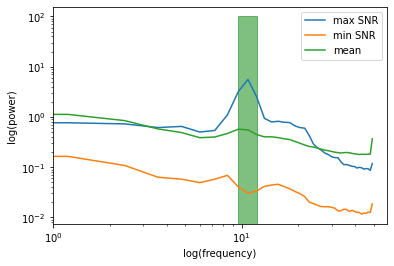

In [23]:
psd, freqs = mne.time_frequency.psd_array_welch(
    ssd_sources_epochs, sfreq=raw.info['sfreq'], n_fft=1000)
below50 = freq_mask(freqs, 0, 50)
bandfilt = freq_mask(freqs, freqs_sig[0],freqs_sig[1])
psd=psd.mean(axis=0)
plt.figure()
plt.loglog(freqs[below50], psd[0, below50], label='max SNR')
plt.loglog(freqs[below50], psd[-1, below50], label='min SNR')
plt.loglog(freqs[below50], psd[:, below50].mean(axis=0), label='mean')
plt.fill_between(freqs[bandfilt], 0, 100,\
                color='green', alpha=0.5)
plt.xlabel("log(frequency)")
plt.ylabel("log(power)")
plt.legend()


#### the pick is also enhanced by the epoched approach